# Twitter Sentiment Analysis

In [ ]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.8 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 8.3 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220527125636 requires keras<2.9,>=2.8.0rc0, but you have keras 2.9.0 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 8.5 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0


In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Settings

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 3
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/training.1600000.processed.noemoticon.csv", encoding='latin-1')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Dataset size:", len(df))

Dataset size: 1599999


In [ ]:
df = df.rename(columns = {"0": "target", "1467810369": "ids", "Mon Apr 06 22:19:45 PDT 2009":"date", "NO_QUERY":"flag", "_TheSpecialOne_": "user", "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D": "text"})

In [ ]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 506 ms, sys: 2.26 ms, total: 508 ms
Wall time: 515 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

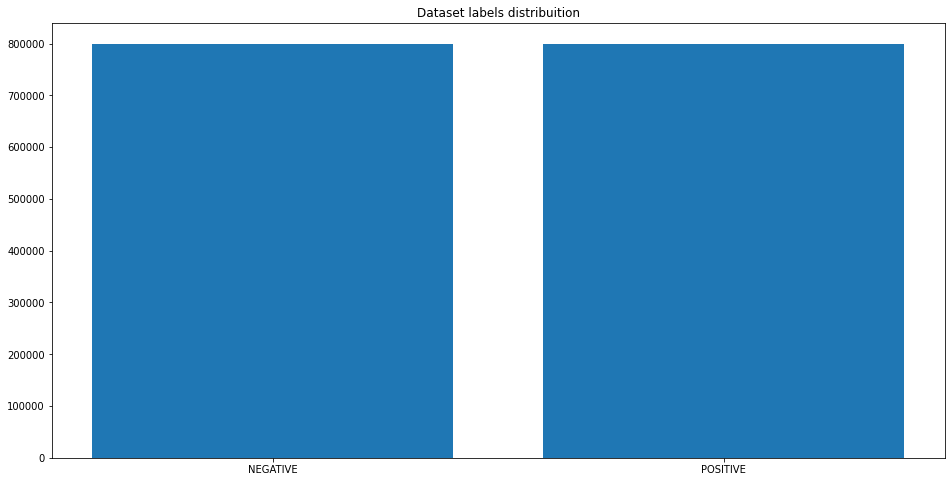

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Pre-Process dataset

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1min 2s, sys: 436 ms, total: 1min 3s
Wall time: 1min 4s


### Split train and test

In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1279999
TEST size: 320000


In [ ]:
df_train = df_train.iloc[0:100000,:]
df_train.shape

(100000, 6)

### Word2Vec 

In [ ]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 159 ms, sys: 67 ms, total: 226 ms
Wall time: 228 ms


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

2022-06-20 17:06:35,307 : INFO : collecting all words and their counts
2022-06-20 17:06:35,310 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-06-20 17:06:35,343 : INFO : PROGRESS: at sentence #10000, processed 72235 words, keeping 13814 word types
2022-06-20 17:06:35,376 : INFO : PROGRESS: at sentence #20000, processed 144002 words, keeping 21347 word types
2022-06-20 17:06:35,409 : INFO : PROGRESS: at sentence #30000, processed 215863 words, keeping 27558 word types
2022-06-20 17:06:35,443 : INFO : PROGRESS: at sentence #40000, processed 288775 words, keeping 32794 word types
2022-06-20 17:06:35,475 : INFO : PROGRESS: at sentence #50000, processed 361030 words, keeping 37709 word types
2022-06-20 17:06:35,508 : INFO : PROGRESS: at sentence #60000, processed 432872 words, keeping 42207 word types
2022-06-20 17:06:35,541 : INFO : PROGRESS: at sentence #70000, processed 504867 words, keeping 46410 word types
2022-06-20 17:06:35,575 : INFO : PROGRESS: at s

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 6398


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-06-20 17:06:42,071 : INFO : training model with 8 workers on 6398 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2022-06-20 17:06:43,171 : INFO : EPOCH 1 - PROGRESS: at 58.16% examples, 310038 words/s, in_qsize 15, out_qsize 1
2022-06-20 17:06:43,586 : INFO : worker thread finished; awaiting finish of 7 more threads
2022-06-20 17:06:43,590 : INFO : worker thread finished; awaiting finish of 6 more threads
2022-06-20 17:06:43,599 : INFO : worker thread finished; awaiting finish of 5 more threads
2022-06-20 17:06:43,605 : INFO : worker thread finished; awaiting finish of 4 more threads
2022-06-20 17:06:43,644 : INFO : worker thread finished; awaiting finish of 3 more threads
2022-06-20 17:06:43,669 : INFO : worker thread finished; awaiting finish of 2 more threads
2022-06-20 17:06:43,677 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-06-20 17:06:43,678 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-06-2

CPU times: user 1min 36s, sys: 793 ms, total: 1min 37s
Wall time: 53 s


(18457390, 23032032)

In [ ]:
w2v_model.wv.most_similar("love")

2022-06-20 17:08:17,665 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.44061708450317383),
 ('loves', 0.39117228984832764),
 ('loved', 0.3862961530685425),
 ('loooove', 0.36984485387802124),
 ('lovee', 0.3698398470878601),
 ('loving', 0.34140104055404663),
 ('rocks', 0.3305228352546692),
 ('joe', 0.32788875699043274),
 ('ddlovato', 0.32727354764938354),
 ('goo', 0.3241972327232361)]

### Tokenize Text

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 57825
CPU times: user 1.65 s, sys: 10 ms, total: 1.66 s
Wall time: 1.67 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 7.23 s, sys: 48.6 ms, total: 7.28 s
Wall time: 7.31 s


### Label Encoder 

In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (100000, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (100000, 300)
y_train (100000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [ ]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(57825, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          17347500  
                                                                 
 dropout_1 (Dropout)         (None, 300, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 17,508,001
Trainable params: 160,501
Non-trainable params: 17,347,500
_________________________________________________________________


### Compile model

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/3
88/88 [==============================] - ETA: 0s - loss: 0.5759 - accuracy: 0.6931 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-06-20 17:30:44,139 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


88/88 [==============================] - 1300s 15s/step - loss: 0.5759 - accuracy: 0.6931 - val_loss: 0.5187 - val_accuracy: 0.7490 - lr: 0.0010
Epoch 2/3
88/88 [==============================] - ETA: 0s - loss: 0.5392 - accuracy: 0.7243 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-06-20 17:52:41,720 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


88/88 [==============================] - 1318s 15s/step - loss: 0.5392 - accuracy: 0.7243 - val_loss: 0.5055 - val_accuracy: 0.7551 - lr: 0.0010
Epoch 3/3
88/88 [==============================] - ETA: 0s - loss: 0.5261 - accuracy: 0.7339 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-06-20 18:15:03,755 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


88/88 [==============================] - 1342s 15s/step - loss: 0.5261 - accuracy: 0.7339 - val_loss: 0.4987 - val_accuracy: 0.7576 - lr: 0.0010
CPU times: user 1h 56min 19s, sys: 7min 53s, total: 2h 4min 12s
Wall time: 1h 6min 25s


### Evaluate

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 966s 3s/step - loss: 0.5063 - accuracy: 0.7532

ACCURACY: 0.7531874775886536
LOSS: 0.5063361525535583
CPU times: user 28min 50s, sys: 1min 39s, total: 30min 30s
Wall time: 16min 22s


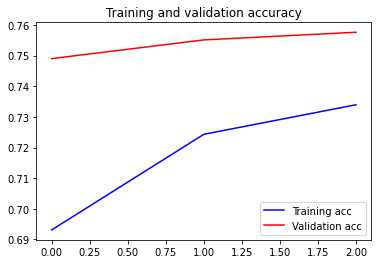

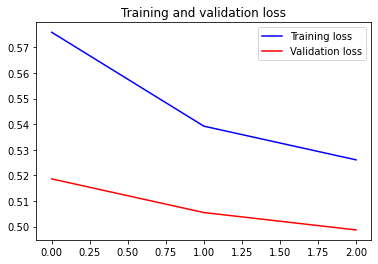

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict("I love the music")

{'elapsed_time': 0.7659151554107666,
 'label': 'POSITIVE',
 'score': 0.9596109390258789}

In [ ]:
predict("I hate the rain")

{'elapsed_time': 0.11830449104309082,
 'label': 'NEGATIVE',
 'score': 0.034288644790649414}

In [ ]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.2740638256072998,
 'label': 'NEUTRAL',
 'score': 0.5855532884597778}

### Confusion Matrix

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 1142s 28s/step
CPU times: user 28min 14s, sys: 7min 42s, total: 35min 57s
Wall time: 19min 22s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

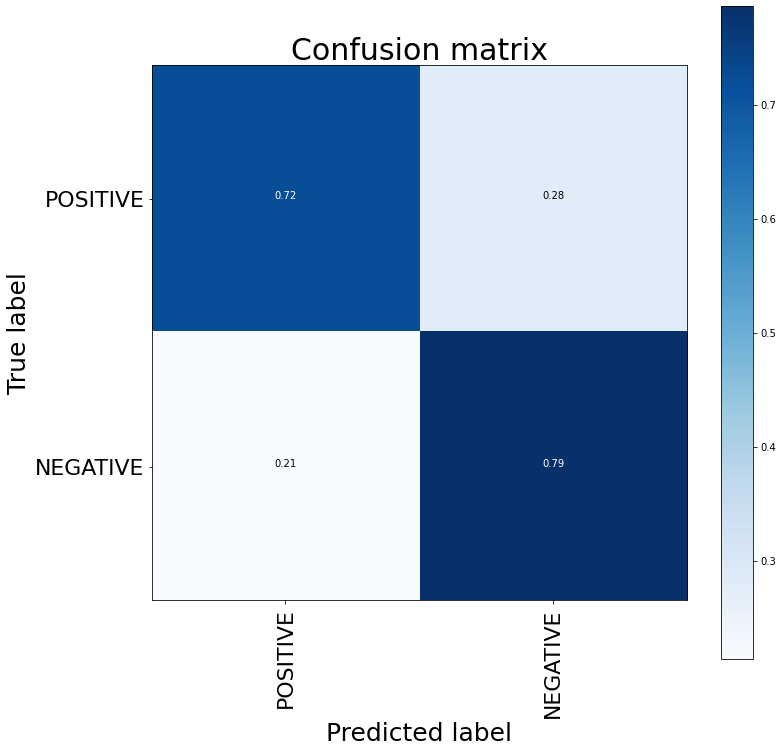

CPU times: user 1.43 s, sys: 26.7 ms, total: 1.46 s
Wall time: 1.53 s


In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.77      0.72      0.74    159494
    POSITIVE       0.74      0.79      0.76    160506

    accuracy                           0.75    320000
   macro avg       0.75      0.75      0.75    320000
weighted avg       0.75      0.75      0.75    320000



### Accuracy Score

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

0.7531875

### Save model

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2022-06-20 19:41:47,851 : INFO : saving Word2Vec object under model.w2v, separately None
2022-06-20 19:41:47,856 : INFO : not storing attribute vectors_norm
2022-06-20 19:41:47,863 : INFO : not storing attribute cum_table
2022-06-20 19:41:48,186 : INFO : saved model.w2v
